## Sensitivity Analysis for Non Parametric Models
Sensitivity Analysis helps us study how robust our results our against the presence of unobserved confounders. <br>
The omitted variable bias gives us a measure of how the inclusion of an omitted covariate (confounder) changes the estimated effect. <br>
In https://github.com/py-why/dowhy/blob/master/docs/source/example_notebooks/sensitivity_analysis_testing.ipynb , we saw how the bias depended on linear partial R^2 values and calculated the adjusted estimate values depending on the relative strength of the confounder with the outcome and treatment. We now generalize the linear partial R^2 to non-parametric partial R^2.<br>
When the Conditional Expectation Function is not linear, the strength of association between the confounder u and outcome y, treatment t can be measured by Pearson's nonparametric R^2. <br>
We analyze the omitted variable bias and derive inferences on this bias under various hypotheses on the strength of confounding.
We see that the bound on the bias depends on the non parametric partial R^2 of the unobserved confounders with outcome (r2yu_tw) and treatment (r2tu_w). <br>
Partial R^2 of outcome Y with confounder U given treatment T and common causes W is given by <br>
R2yu_tw = ( R2y_utw - R2y_tw) / ( 1 - R2y_tw ) <br>
Similarly, R2tu_w = ( R2t_uw - R2t_w ) / ( 1 - R2t_w ) <br>

AddUnobservedCommonCause class supports three methods:
1) Simulation based <br>
2) Linear partial R2 based : Sensitivity Analysis for linear models.<br>
3) Non-Parametric partial R2 based : Sensitivity Analyis for non-parametric models. Two important quantities used to estimate the bias are alpha and g<br> <br>
g := E[Y | T, W, Z] denotes the long regression function<br>
g_s := E[Y | T, W] denotes the short regression function<br>
α := (T - E[T | W, Z] ) / (E(T - E[T | W, Z]) ^ 2) denotes long reisz representer<br>
α_s := (T - E[T | W] ) / (E(T - E[T | W]) ^ 2) denotes short reisz representer<br> <br>
Bias = E(g_s - g)(α_s - α) for partially linear models<br>
Thus, The bound is the product of additional variations that omitted confounders generate in the regression function and in the reisz representer for partially linear models.<br>
Whereas for non parametric models, Bias = S * Cg * Calpha <br>
where Cg and Calpha are explanatory powers of the confounder where 
- Cg^2 = r2yu_tw
- Calpha^2 = r2tu_w / (1 - r2tu_w
- S^2 = E(Y - g_s) ^ 2 * E(α_s ^ 2) <br>
This method is based on Chernozhukov et al. Long Story Short: Omitted Variable Bias in Causal Machine Learning.  https://arxiv.org/abs/2112.13398. <br>

### Step 1: Load required packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Required libraries
import os, sys
sys.path.append(os.path.abspath("../../../"))
import dowhy
from dowhy import CausalModel
import dowhy.datasets
import numpy as np
from dowhy.causal_refuters.reisz import create_polynomial_function

### Step 2: Load the dataset 
We create a dataset with linear relationships between common causes and treatment, and common causes and outcome. Beta is the true causal effect.

In [3]:
np.random.seed(100) 
data = dowhy.datasets.linear_dataset( beta = 10,
                                      num_common_causes = 7,
                                      num_samples = 500,
                                      num_treatments = 1,
                                     num_effect_modifiers = 1,
                                     stddev_treatment_noise = 5,
                                     stddev_outcome_noise = 5
                                    )

### Step 3: Create Causal Model
Remove one of the common causes to simulate unobserved confounding and create a causal model with the modified data and causal graph.

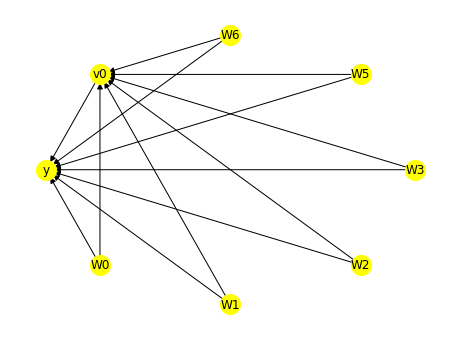

In [4]:
data["df"] = data["df"].drop("W4", axis = 1)
graph_str = 'graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"]  node[ id "W5" label "W5"] node[ id "W6" label "W6"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ source "W5" target "v0"] edge[ source "W6" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"] edge[ source "W5" target "y"] edge[ source "W6" target "y"]]'
model = CausalModel(
            data=data["df"],
            treatment=data["treatment_name"],
            outcome=data["outcome_name"],
            effect_modifiers = data["effect_modifier_names"],
            graph=graph_str,
            test_significance=None,
        )
model.view_model()

### Step 4: Identification

In [5]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                          
─────(E[y|W5,W1,W6,W0,W3,W2])
d[v₀]                        
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W5,W1,W6,W0,W3,W2,U) = P(y|v0,W5,W1,W6,W0,W3,W2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Step 5: Estimation

In [6]:
import econml
from sklearn.ensemble import GradientBoostingRegressor
estimate = model.estimate_effect(identified_estimand, 
                                    method_name="backdoor.econml.dml.NonParamDML",
                                    method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),
                                                        'model_final': GradientBoostingRegressor()
                                                       },
                                        'fit_params': {'cache_values': True,}
                                     })

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


### Step 6: Refutation and Sensitivity Analysis
- <b>identified_estimand</b>: An instance of the identifiedEstimand class that provides the information with respect to which causal pathways are employed when the treatment effects the outcome<br>
- <b>estimate</b>: An instance of CausalEstimate class. The estimate obtained from the estimator for the original data.<br>
- <b>method_name</b>: Refutation method name <br>
- <b>simulated_method_name</b>: "non-parametric-partial-R2" for Non Parametric Sensitivity Analysis<br>
- <b>num_splits</b>: number of splits for cross validation. (default = 5) <br>
- <b>shuffle_data</b> : shuffle data or not before splitting into folds (default = False)<br>
- <b>shuffle_random_seed</b>: seed for randomly shuffling data<br>
- <b>alpha_s_param_dict</b>: dictionary with parameters for finding alpha_s: <br>
    - <b>reisz_functions</b>: List of polynomial functions of n degree to approximate reisz representer created using create_polynomial_function
    - <b>l2_regularizer</b>: l2 penalty while modeling (default = 1e-3)
    - For details of other parameters other parameters of ReiszRepresenter class see: https://econml.azurewebsites.net/_autosummary/econml.grf.CausalForest.html 
- <b>g_s_estimator_list</b>: list of estimator objects for finding g_s. Example: <br> 
[<br> RandomForestRegressor(n_estimators = 100, random_state = 120),<br> 
Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), numeric_features)], remainder='passthrough')), ('lasso_model', Lasso())]),<br>
ReiszRegressor(regression_functions = create_polynomial_function(max_degree), min_var_leaf_on_val = True,min_impurity_decrease = 1e-4, max_samples = 0.80)<br>
]
- <b>g_s_estimator_param_list</b>: list of dictionaries with parameters for tuning respective estimators in g_s_estimator_list. Example: <br>
[ { 'n_estimators' : [50], 
    'max_depth' : [3, 4, 5],
    'min_samples_leaf' : [10,50]
  },<br>{'lasso_model__alpha' : [ 0.01, 0.001, 1e-4, 1e-5, 1e-6]},<br>
  {'regression_functions' : [create_polynomial_function(2), create_polynomial_function(4)],
   'min_samples_leaf' : [10, 50],
   'min_var_fraction_leaf' : [0.01, 0.1],
   'l2_regularizer' : [1e-2, 1e-3]
   }<br>
]
    - The parameters for ReiszRegressor
        - <b>regression_functions</b>: List of polynomial functions of n degree to approximate reisz regressor created using create_polynomial_function
        - <b>l2_regularizer</b>: l2 penalty while modeling (default = 1e-3)
        - For details of other parameters other parameters of ReiszRegressor class see: https://econml.azurewebsites.net/_autosummary/econml.grf.CausalForest.html 
- <b>benchmark_common_causes</b>: Name of the covariates used to bound the strengths of unobserved confounder<br>
- <b>effect_fraction_on_treatment</b>: Strength of association between unobserved confounder and treatment compared to benchmark covariate<br>
- <b>effect_fraction_on_outcome</b>: Strength of association between unobserved confounder and outcome compared to benchmark covariate<br>
- <b>plot_estimate</b>: Generate contour plot for estimate while performing sensitivity analysis. (default = True). To override the setting, set plot_estimate = False.

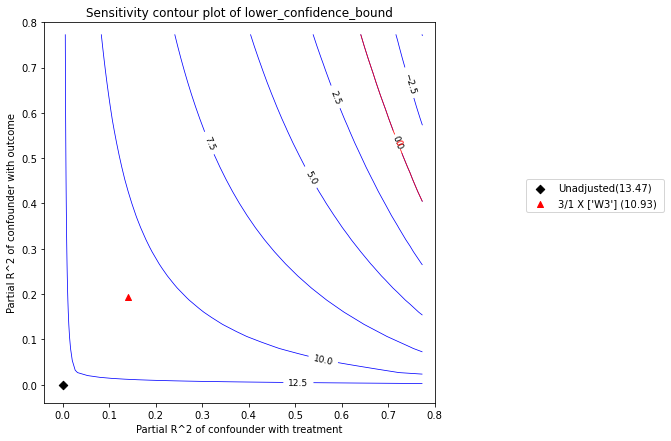

In [7]:
refute = model.refute_estimate(identified_estimand, estimate ,
                               method_name = "add_unobserved_common_cause",
                               simulated_method_name = "non-parametric-partial-R2",
                               alpha_s_param_dict =  {'reisz_functions': [create_polynomial_function(2), create_polynomial_function(1)],
                                    'min_samples_leaf': [10, 50],
                                    'min_var_fraction_leaf': [0.01, 0.1],
                                    'l2_regularizer': [1e-5, 1e-3],
                                    'max_depth': [5, None]},
                               benchmark_common_causes = ["W3"],
                               effect_fraction_on_treatment = 3
                              )

The x axis shows hypothetical partial R2 values of unobserved confounder(s) with the treatment. The y axis shows hypothetical partial R2 of unobserved confounder(s) with the outcome.<br>
The contour levels represent adjusted lower confidence bound for unobserved confounders with hypothetical partialR2 values when these would be included in full regression model. <br>
The black diamond shows the original estimate (theta_s) without considering the unobserved confounders<br>
The red line is the critical threshold: confounders with such strength or stronger are sufficient to invalidate the research conclusions.

In [8]:
refute.results

,r2tu_w,r2yu_tw,short estimate,bias,lower_ate_bound,upper_ate_bound,lower_confidence_bound,upper_confidence_bound
0,0.140065,0.19269,13.465745,1.888072,11.577673,15.353817,10.929158,16.041229


##### Parameter List for plot function
- <b>plot_type</b>: possible values are 'bias','lower_ate_bound','upper_ate_bound','lower_confidence_bound','upper_confidence_bound'<br>
- <b>x_limit</b>: plot's maximum x_axis value (default = 0.8) <br>
- <b>y_limit</b>: plot's minimum y_axis value (default = 0.8) <br>
- <b>num_points_per_contour</b>: number of points to calculate and plot each contour line (default = 200) <br>
- <b>plot_size</b>: tuple denoting the size of the plot (default = (7,7))<br>
- <b>contours_color</b>: color of contour line (default = blue)<br>
String or array. If array, lines will be plotted with the specific color in ascending order.<br>
- <b>critical_contour_color</b>: color of threshold line (default = red)<br>
- <b>label_fontsize</b>: fontsize for labelling contours (default = 9)<br>
- <b>contour_linewidths</b>: linewidths for contours (default = 0.75)<br>
- <b>contour_linestyles</b>: linestyles for contours (default = "solid") See : https://matplotlib.org/3.5.0/gallery/lines_bars_and_markers/linestyles.html<br>
- <b>contours_label_color</b>: color of contour line label (default = black)<br>
- <b>critical_label_color</b>: color of threshold line label (default = red)<br>
- <b>unadjusted_estimate_marker</b>: marker type for unadjusted estimate in the plot (default = 'D')
See: https://matplotlib.org/stable/api/markers_api.html <br>
- <b>unadjusted_estimate_color</b>: marker color for unadjusted estimate in the plot (default = "black")<br>
- <b>adjusted_estimate_marker</b>: marker type for bias adjusted estimates in the plot (default = '^')<br>
- <b>adjusted_estimate_color</b>: marker color for bias adjusted estimates in the plot (default = "red")<br>
- <b>legend_position</b>:tuple denoting the position of the legend (default = (1.6, 0.6))<br>

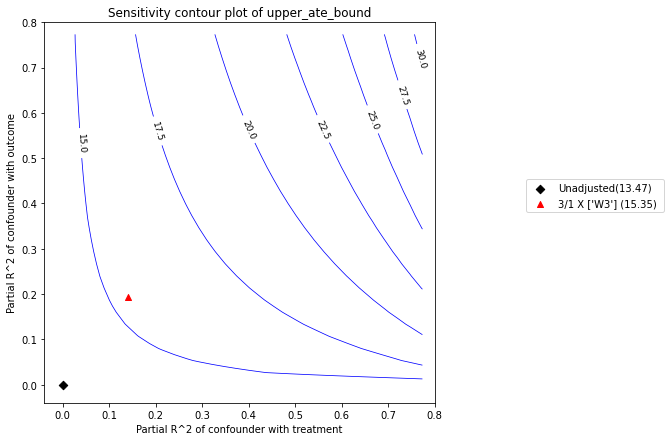

In [9]:
refute.plot(plot_type = "upper_ate_bound")

No contour levels were found within the data range.


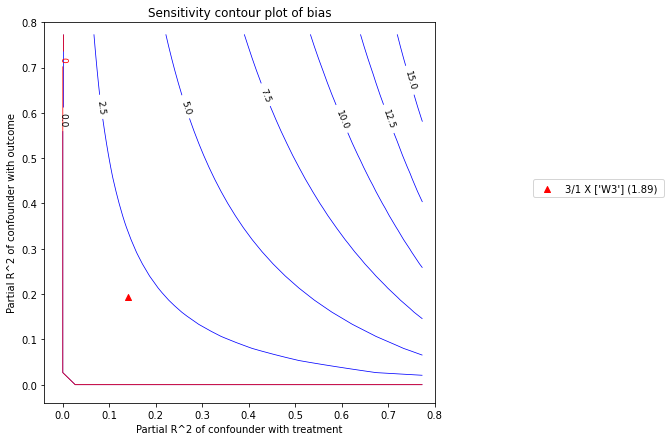

In [10]:
refute.plot(plot_type = "bias")

In [11]:
refute.RV

The robustness value measures the minimal equal strength of r2yu_tw and r2tu_w such the bound for the average treatment effect would include zero. It can be between 0 and 1.<br>
A low robustness value implies that the results can be changed even by the presence of weak confounders whereas a robustness value close to 1 means the treatment effect can handle strong confounders explaining  almost all residual variation of the treatment and the outcome.<br>
A robustness value of 0.7 implies that confounders with r2yu_tw and r2tu_w values less than 0.7 would not be sufficient enough to bring down the estimates to zero.

## Sensitivity Analysis for Partially Linear Models
Partially Linear Models are where the conditional expectation functions (CEF) of the outcome are linearly separable in the treatment.<br>
Here, we perform partial sensitivity analysis for LinearDML estimator from econml. This method is computationally faster.<br>
The first four steps are common:<br>
1. Load Packages
2. Load Dataset
3. Create Causal Model
4. Identification

### Step 5: Estimation
Partial Linear Sensitivity Analysis is aperformed automatically if LinearDML estimator from econml is used for estimation.<br>
 Set <b>cache_values</b> = <b>True</b> in fit_params to cache the results of first stage estimation.

In [12]:
import econml
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, 
                                    method_name="backdoor.econml.dml.LinearDML",
                                    method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),
                                                        'linear_first_stages': False
                                                       },
                                        'fit_params': {'cache_values': True,}
                                     })

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


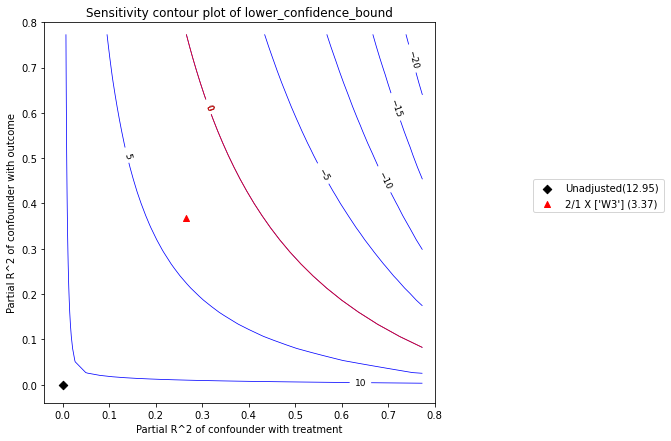

In [13]:
refute = model.refute_estimate(identified_estimand, dml_estimate ,
                               method_name = "add_unobserved_common_cause",
                               simulated_method_name = "non-parametric-partial-R2",
                               benchmark_common_causes = ["W3"],
                               effect_fraction_on_treatment = 2
                              )

The x axis shows hypothetical partial R2 values of unobserved confounder(s) with the treatment. The y axis shows hypothetical partial R2 of unobserved confounder(s) with the outcome.<br>
The contour levels represent adjusted lower confidence bound for unobserved confounders with hypothetical partialR2 values when these would be included in full regression model. <br>
The black diamond shows the original estimate (theta_s) without considering the unobserved confounders<br>
The red line is the critical threshold: confounders with such strength or stronger are sufficient to invalidate the research conclusions.<br>

In [14]:
refute.results

,r2tu_w,r2yu_tw,short estimate,bias,lower_ate_bound,upper_ate_bound,lower_confidence_bound,upper_confidence_bound
0,0.265161,0.367967,12.95425,7.525211,5.42904,20.479461,3.373898,22.962506


In [15]:
refute.RV

The robustness value measures the minimal equal strength of r2yu_tw and r2tu_w such the bound for the average treatment effect would include zero. <br>
A robustness value of 0.4 implies that confounders with r2yu_tw and r2tu_w values less than 0.4 would not be sufficient enough to bring down the estimates to zero.